In [30]:
%load_ext autoreload
%autoreload 2
from MVC_env import MVC_environement
from DQN_network import embedding_network
import numpy as np
import networkx as nx
import math
import torch
from tqdm import tqdm_notebook as tqdm
import pickle
from heapdict import heapdict
from networkx.algorithms.approximation import min_weighted_vertex_cover
import random
import itertools
import warnings
warnings.filterwarnings("ignore")
def pickle_save(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data , f)
def pickle_load(file_name):
    with open(file_name,'rb') as f:
        return pickle.load(f)


np.random.seed(19960214)
random.seed(19960214)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
#sem_radius = [[]]*13
sem_radius = [[] for _ in range(13)]
sem_radius[5].append(3)
sem_radius

[[], [], [], [], [], [3], [], [], [], [], [], [], []]

In [18]:
def is_vertex_cover(graph , cover):
    cover_edge = 0
    total_edge = len(graph.edges())
    checked_set = set()
    for c in cover:
        checked_set.add(c)
        for u in list(graph.neighbors(c)):
            if u not in checked_set:
                cover_edge += 1
            
    return cover_edge == total_edge

def mvc_bb(graph , UB = None , C = None):
    
    
    def DegLB():
    
        degree_list = nx.degree(graph)
        hd = heapdict()
        for v , d in degree_list:
            hd[v] = -d
        
        num_edge = len(graph.edges())
        count_edge = 0
        lb = 0
        select_nodes = []
        while count_edge < num_edge:
            cur_v , cur_degree = hd.popitem()
            count_edge += -(cur_degree)
            select_nodes.append(cur_v)
            for u in graph.neighbors(cur_v):
                if u in select_nodes:
                    continue
                hd[u] += 1
        cur_v , cur_degree = hd.popitem()
        graph_plum = graph.copy()
        graph_plum.remove_nodes_from(select_nodes)
        E_plum = len(graph_plum.edges())
        if cur_degree > 0:
            E_plum /= cur_degree
        return math.floor( len(select_nodes) + E_plum )
    
    if len(graph.edges()) == 0:
        #return len(C)
        return C
    LB = DegLB()
    if len(C) + LB >= UB:
        #return UB
        return [i for i in range(UB)]
    
    degree_list = nx.degree(graph)
    v , d = max(degree_list , key = lambda a : a[1])
    
    C1 = C[:]
    C2 = C[:]
    graph_1 = graph.copy()
    C1.extend(list(graph.neighbors(v)))
    C1.append(v)
    graph_1.remove_nodes_from(C1)
    C1= mvc_bb(graph_1 , UB , C1)

    C2.append(v)
    graph_2 = graph.copy()
    graph_2.remove_node(v)
    C2 = mvc_bb(graph_2 , min(UB , len(C1)) , C2 )

    if len(C1)>len(C2):
        return C2
    else:
        return C1


In [4]:
import numpy as np
from collections import namedtuple

experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])

class replay_buffer():
    def __init__(self , max_size):
        self.buffer = np.zeros(  [max_size],dtype = experience)
        self.max_size = max_size
        self.size = 0
        self.idx = -1
    def push(self , new_exp):
        if(self.size >= self.max_size):
            self.idx = (self.idx+1) % self.max_size
        else:
            self.idx = self.idx + 1
            self.size += 1
        
        self.buffer[self.idx] = new_exp
    
    def sample(self , batch_size):
        batch = np.random.choice(np.arange(self.size) , size = batch_size , replace=False)
        
        return self.buffer[[batch]]
    


In [5]:
def approximate_algo(env):
    edge_list = env.edges[:]
    
    C =  set()
    #print(len(edge_list))
    while( len(edge_list) > 0):
        #print(len(edge_list))
        e = edge_list[-1]
        u,v = e
        C.add(u)
        C.add(v)
        to_remove = []
        for ed in edge_list:
            if (u in ed) or (v in ed):
                to_remove.append(ed)
        for ed in to_remove:
            edge_list.remove(ed)
    
    for v in C:
        env.take_action(v)
    
    return C



In [6]:
def validation(dqn , validation_graph , device = 'cuda:0'):
    objective_vals = []
    for g in validation_graph:
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        Xv = Xv.clone()
        Xv = Xv.cuda()
        graph = graph.to(device)
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        while done == False:
            #Xv = Xv.cuda()
            Xv = Xv.to(device)
            val = dqn(graph , Xv)[0]
            val[selected] = -float('inf')
            action = int(torch.argmax(val).item())
            Xv_next , reward , done = env.take_action(action)
            non_selected.remove(action)
            selected.append(action)
            Xv = Xv_next
        objective_vals.append(len(selected))
    return sum(objective_vals)/len(objective_vals)

In [31]:
def training_validation( validation_a , validation_bs , validation_per_epoch = 30 , num_validation = 20  ,
                        type_train = 'er', graph_size = 50 , device = 'cuda:1' , 
                        density = 0.1 , opt_train = -1 , opt_val=[] , imitation = False):
    
    torch.cuda.manual_seed_all(19960214) # for reproduce
    torch.manual_seed(19960214) # for reproduce
    np.random.seed(19960214)
    random.seed(19960214)
    MAX_EPISODE = validation_per_epoch * num_validation + 1
    dqn = embedding_network(emb_dim=64 , T = 5 , device=device , init_factor = 10 , w_scale = 0.01).double()
    target_net = embedding_network(emb_dim=64 , T = 5,device=device , init_factor = 10 , w_scale = 0.01).double()
    target_net.load_state_dict(dqn.state_dict())
    EPS_START = 1.00
    EPS_END = 0.05
    EPS_DECAY = 10000
    steps_done = 0
    loss_func = torch.nn.MSELoss()
    USE_CUDA = torch.cuda.is_available()
    N_STEP = 2
    reward_history = []
    batch_size = 128
    buffer = replay_buffer(50000)
    optimizer = torch.optim.Adam(dqn.parameters(),lr=0.00002 , amsgrad=True)
    #optimizer = torch.optim.RMSprop(dqn.parameters(), lr = 0.0001)
    validation_result = []
    another_result = [[] for _ in range(len(validation_bs))]
    reward_history = []
    res = []
    if opt_train == -1:
        for g in validation_a:
            #env = MVC_environement(g)
            #C = approximate_algo(env)
            #C = min_weighted_vertex_cover(g)
            C = mvc_bb(g , len(g.nodes()) , [])
            res.append(len(C))
        approx_val = sum(res)/len(res)
    else:
        approx_val = opt_train
    approx_val_anothers = []
    if len(opt_val) == 0:
        for validation_b in validation_bs:
            res = []
            for g in validation_b:
                #env = MVC_environement(g)
                #C = approximate_algo(env)
                #C = min_weighted_vertex_cover(g)
                C = mvc_bb(g , len(g.nodes()) , [])
                res.append(len(C))
            approx_val_another = sum(res)/len(res)
            approx_val_anothers.append(approx_val_another)
    else:
        approx_val_anothers = opt_val

    if USE_CUDA:
        #dqn = dqn.cuda()
        #target_net = target_net.cuda()
        dqn.to(device)
        target_net.to(device)
    fitted_q_exp = namedtuple("fitted_exp" , ['graph','Xv','action','reward'])
    
    #print('density',nx.density(validation_a[0]),nx.density(validation_b[0]))
    print('value',approx_val,end=' ' )
    for va in approx_val_anothers:
        print(va,end=' ')
    print('')
    for e in tqdm(range(MAX_EPISODE)):
        def density_to_edge_ba(n , p):
            return math.ceil( p *n  /2)
        #p = np.random.uniform(0.05,0.3)
        if type_train == 'er':
            g = nx.erdos_renyi_graph(n = graph_size , p = density)
        elif type_train == 'ba':
            ba_m = density_to_edge_ba(graph_size , density)
            g = g = nx.barabasi_albert_graph(graph_size , ba_m)
        else:
            raise 'Not Implemented'
        
        #if e % 2 == 0:
        #    imitation = False
        #else:
        #    imitation = True
        
        if imitation:
            opt_sol = mvc_bb(g , len(g.nodes()) , [])
            idx = 0
        env = MVC_environement(g)
        
        Xv , graph = env.reset_env()
        Xv = Xv.clone()
        graph = torch.unsqueeze(graph,  0)
        done = False
        
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        eps_reward = []
        
        if USE_CUDA:
            graph = graph.to(device)
            Xv = Xv.to(device)
        N = 0
        reward_list = []
        fitted_experience_list = []
        cur_episode_loss = []
        
        
        idx = 0
        
        while done == False:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)

            if USE_CUDA:
                #Xv = Xv.cuda()
                Xv = Xv.to(device)
            
            if imitation:
                #print(len(opt_sol) , idx , done)
                action = opt_sol[idx]
                #print(action)
                idx += 1
            else:
                if np.random.uniform() > eps_threshold:
                    val = dqn(graph , Xv)[0]
                    #print(val)
                    #break
                    val[selected] = -float('inf')
                    action = int(torch.argmax(val).item())
                else:
                    action = int(np.random.choice(non_selected))
            
            Xv_next , reward , done = env.take_action(action)
            #print('total',len(env.edges) , 'cover' , env.covered_edges)
            
            eps_reward.append(reward)
            Xv_next = Xv_next.clone()
            fit_ex = fitted_q_exp(graph , Xv , action , reward)
            fitted_experience_list.append(fit_ex)
            
            non_selected.remove(action)
            selected.append(action)
            N += 1 
            reward_list.append(reward)
            if N >= N_STEP:
                n_reward = sum(reward_list)
                #reward_n = reward
                n_prev_ex = fitted_experience_list[0]
                n_graph = n_prev_ex.graph
                n_Xv = n_prev_ex.Xv
                n_action = n_prev_ex.action
                #ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
                #print(sum(n_Xv[0]),sum( Xv_next[0]))
                ex = experience(n_graph , n_Xv , torch.tensor([n_action]) , torch.tensor([n_reward]) , Xv_next , done)
                buffer.push(ex)
                fitted_experience_list.pop(0)
                reward_list.pop(0)
            Xv = Xv_next
            
            steps_done += 1

            if buffer.size >= batch_size:
                batch = buffer.sample(batch_size)
                batch = experience(*zip(*batch))
                batch_graph = torch.cat(batch.graph)
                batch_state = torch.cat(batch.Xv)
                batch_action = torch.cat(batch.action)
                batch_reward = torch.cat(batch.reward).double()
                batch_next_state = torch.cat(batch.next_Xv)
                non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)

                non_final_graph = batch_graph[non_final_mask]
                non_final_next_state = batch_next_state[non_final_mask]

                next_state_value = torch.zeros(batch_size).detach().double()
                if USE_CUDA:
                    batch_graph = batch_graph.to(device)
                    batch_state = batch_state.to(device)
                    batch_action = batch_action.to(device)
                    batch_reward = batch_reward.to(device)
                    batch_next_state = batch_next_state.to(device)
                    next_state_value = next_state_value.to(device)
                    non_final_graph = non_final_graph.to(device)
                    non_final_next_state = non_final_next_state.to(device)

                pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)

                
                next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
                expected_q = next_state_value + batch_reward
                loss = loss_func(pred_q , expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                cur_episode_loss.append(loss.item())
        #if len(cur_episode_loss) and e % 10 == 0:
        #    print(sum(cur_episode_loss)/len(cur_episode_loss) , eps_threshold)
        if e > 0 and e % 8 == 0:
            target_net.load_state_dict(dqn.state_dict())
        if e > 0 and e % validation_per_epoch == 0:
            v = validation(dqn , validation_a , device=device)
            validation_result.append(v / approx_val)
            for i , validation_b in enumerate(validation_bs):
                v = validation(dqn , validation_b , device=device)
                another_result[i].append(v / approx_val_anothers[i])
                
        reward_history.append(sum(eps_reward))
    return validation_result , another_result  , reward_history , dqn

In [32]:
def density_to_edge_ba(n , p):
    return math.ceil( p *n  /2)
def validation_graph_gen(n , p , num = 100, graph_type = 'er'):
    np.random.seed(19960214)
    random.seed(19960214)
    validation_graph = []
    for i in range(num):
        if graph_type == 'er':
            g = nx.erdos_renyi_graph(n , p)
            validation_graph.append(g)
        elif graph_type == 'ba':
            m = density_to_edge_ba(n , p)
            g = nx.barabasi_albert_graph(n , m)
            validation_graph.append(g)
            
    return validation_graph

def test_with_paras( graph_size , graph_type_a , density_a , graph_type_b , density_b):
    val_a = validation_graph_gen(n = graph_size , p = density_a  , graph_type = graph_type_a)
    val_b = validation_graph_gen(n = graph_size , p = density_b  , graph_type = graph_type_b)
    ba_m = density_to_edge_ba(graph_size , density_a)
    result_a , result_b , _ = training_validation(val_a , val_b , num_validation=25 , validation_per_epoch=10 , 
                                                 type_train = graph_type_a , graph_size = graph_size,
                                                 er_p = density_a , ba_m = ba_m)
    return result_a , result_b

opt [49.0, 37.194, 25.0, 32.274]
value 49.0 37.194 25.0 32.274 


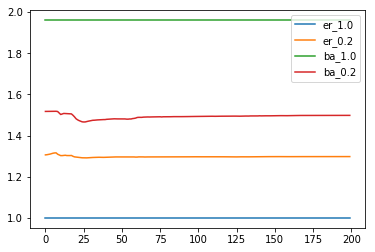

value 37.194 49.0 25.0 32.274 


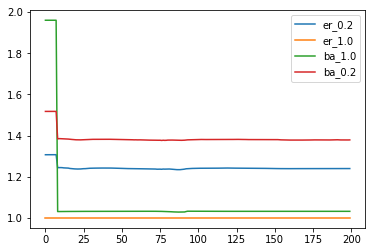

value 25.0 49.0 37.194 32.274 


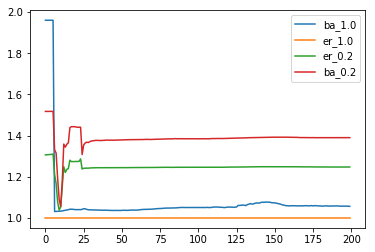

value 32.274 49.0 37.194 25.0 


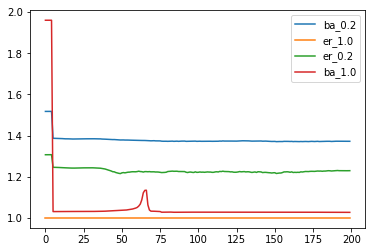

"\n    for j in range(N):\n        if i == j:\n            continue\n        val_size = parameter_list[j][0]\n        val_type = parameter_list[j][1]\n        val_density = parameter_list[j][2]\n        \n        validation_graph = validation_graph_gen(n = val_size , p = val_density \n                                                , num = VALIDATION_GRAPH_NUM , graph_type=val_type)\n        \n        validation_anothers.append(validation_graph)\n        all_graphs.append(validation_graph)\n    \n        legend_word.append('{}_{}'.format(val_type,val_density))\n    validation_result , another_result  , reward_history = training_validation( train_graphs , validation_anothers,\n                                                                              num_validation=20 , validation_per_epoch=10,\n                                                                              type_train= train_type , graph_size=train_size\n                                                                 

In [29]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
graph_size_list = [50]
graph_type_list = ['er' , 'ba']
density_list = [1.0,0.2]

parameter_list = list(itertools.product(graph_size_list , graph_type_list ,density_list))
N = len(parameter_list)
VALIDATION_GRAPH_NUM = 500
'''
performance_dict = {}

all_graphs = []
opt_results = []
for i in range(N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    
    train_graphs = validation_graph_gen(n = train_size , p = train_density 
                                        , num = VALIDATION_GRAPH_NUM , graph_type=train_type)
    
    all_graphs.append(train_graphs)

for i in range(N):
    
    cur_res = []
    
    for j in tqdm(range(VALIDATION_GRAPH_NUM)):
        cur_g = all_graphs[i][j]
        C = mvc_bb(cur_g , len(cur_g.nodes()) , [])
        cur_res.append(len(C))
    opt_results.append(sum(cur_res)/len(cur_res))
'''
print('opt',opt_results)
for i in range(N):
    train_size = parameter_list[i][0]
    train_type = parameter_list[i][1]
    train_density = parameter_list[i][2]
    legend_word = ['{}_{}'.format(train_type,train_density)]
    opt_train = opt_results[i]
    train_graphs = all_graphs[i]
    opt_vals = []
    validation_anothers = []
    for j in range(N):
        
        if i == j:
            continue
        val_size = parameter_list[j][0]
        val_type = parameter_list[j][1]
        val_density = parameter_list[j][2]
        
        validation_anothers.append(all_graphs[j])
        opt_vals.append(opt_results[j])
        legend_word.append('{}_{}'.format(val_type,val_density))
    validation_result , another_result  , reward_history , dqn = training_validation(train_graphs , validation_anothers,
                                                                              num_validation=200 , validation_per_epoch=10,
                                                                              type_train= train_type , graph_size=train_size
                                                                              ,density = train_density , opt_train=opt_train,
                                                                              opt_val = opt_vals, device='cuda:1',
                                                                                    imitation=False)
    plt.plot(validation_result)
    performance_dict[legend_word[0]] = {legend_word[0]:validation_result}
    for v , l in zip(another_result , legend_word[1:]):
        plt.plot(v)
        performance_dict[legend_word[0]][l] = v
    plt.legend(legend_word)
    plt.show()
    
'''
    for j in range(N):
        if i == j:
            continue
        val_size = parameter_list[j][0]
        val_type = parameter_list[j][1]
        val_density = parameter_list[j][2]
        
        validation_graph = validation_graph_gen(n = val_size , p = val_density 
                                                , num = VALIDATION_GRAPH_NUM , graph_type=val_type)
        
        validation_anothers.append(validation_graph)
        all_graphs.append(validation_graph)
    
        legend_word.append('{}_{}'.format(val_type,val_density))
    validation_result , another_result  , reward_history = training_validation( train_graphs , validation_anothers,
                                                                              num_validation=20 , validation_per_epoch=10,
                                                                              type_train= train_type , graph_size=train_size
                                                                              ,density = train_density)
    plt.plot(validation_result)
    performance_dict[legend_word[0]] = {legend_word[0]:validation_result}
    for v , l in zip(another_result , legend_word[1:]):
        plt.plot(v)
        performance_dict[legend_word[0]][l] = v
    plt.legend(legend_word)
    plt.show()
 '''

In [25]:
cur_g = all_graphs[0][0]
C = mvc_bb(cur_g , len(cur_g.nodes()) , [])

In [147]:
performance_dict #0223

{'er_0.15': {'er_0.15': [1.9983119709794437,
   1.9983119709794437,
   1.9983119709794437,
   1.9983941958887543,
   1.998558645707376,
   1.9988053204353085,
   1.9987230955259976,
   1.998558645707376,
   1.9988053204353085,
   1.9988053204353085,
   1.9990519951632406,
   1.8690544135429263,
   1.8674099153567107,
   1.8650253929866987,
   1.8620652962515114,
   1.8600096735187424,
   1.8540072551390567,
   1.849073760580411,
   1.8455380894800484,
   1.842577992744861,
   1.8399467956469164,
   1.8399467956469164,
   1.8420846432889961,
   1.8448802902055623,
   1.850800483675937,
   1.8537605804111246,
   1.8561451027811366,
   1.8595985489721885,
   1.8619830713422005,
   1.8627230955259975,
   1.8637097944377268,
   1.863874244256348,
   1.8646964933494559,
   1.8646964933494559,
   1.8649431680773882,
   1.8651898428053204,
   1.8658476420798065,
   1.865683192261185,
   1.8655187424425634,
   1.8650253929866987,
   1.8649431680773882,
   1.8644498186215235,
   1.86428536880290

In [ ]:
pickle_save(performance_dict , 'validation_result/performance_dict_0218.pkl')

In [193]:
performance_dict = pickle_load('validation_result/performance_dict_0216.pkl')

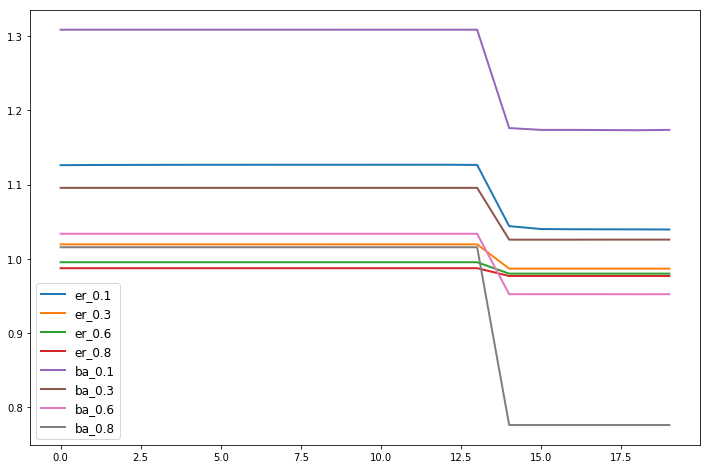

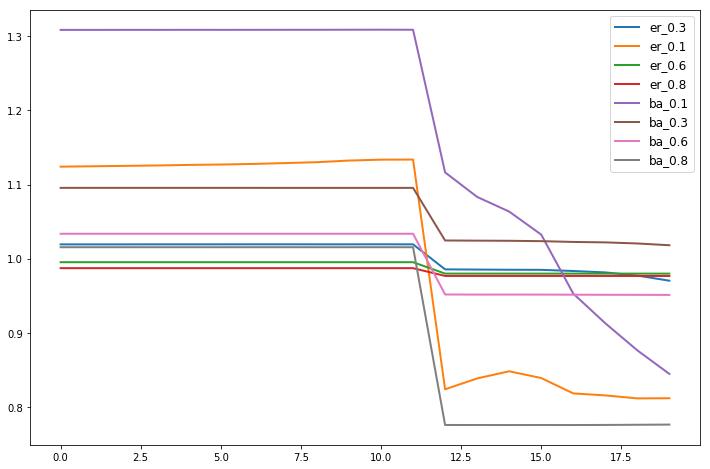

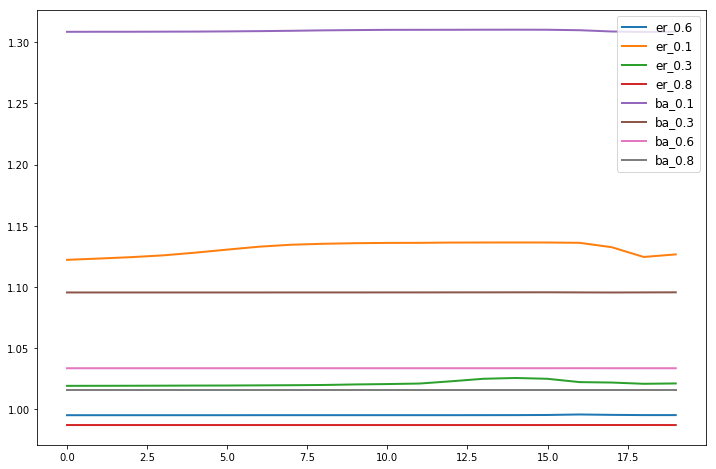

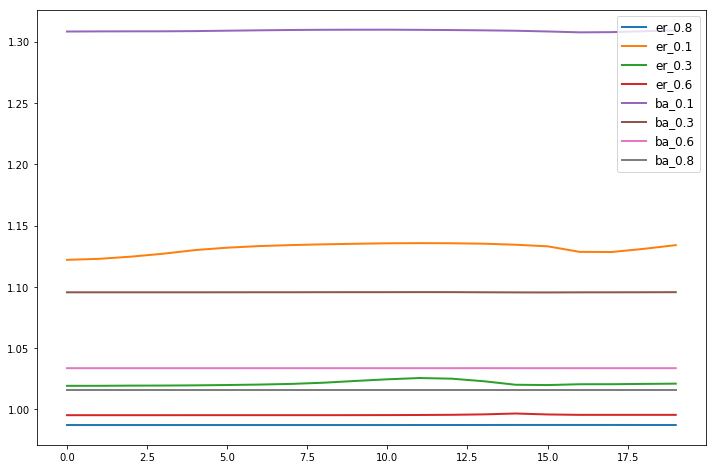

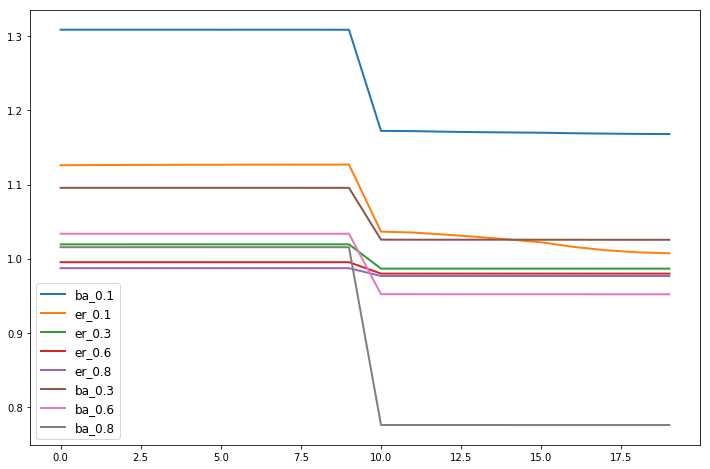

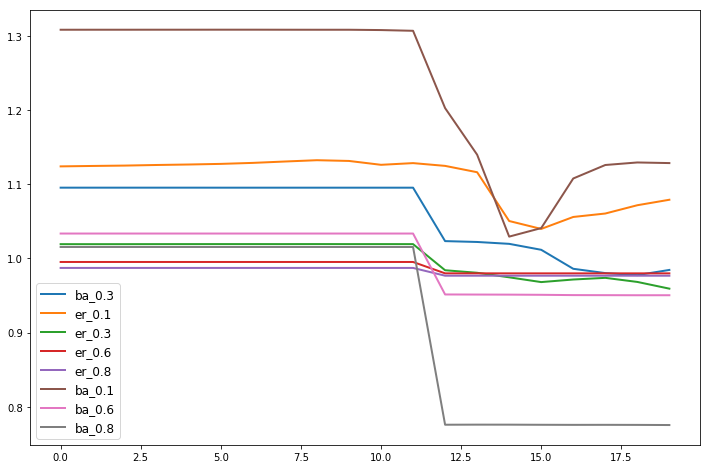

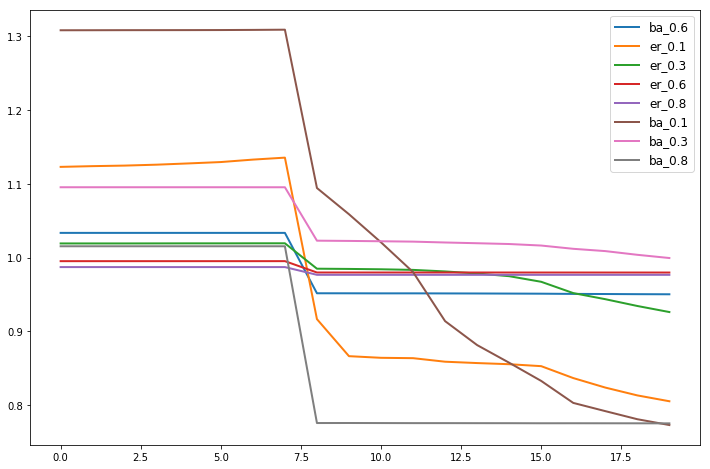

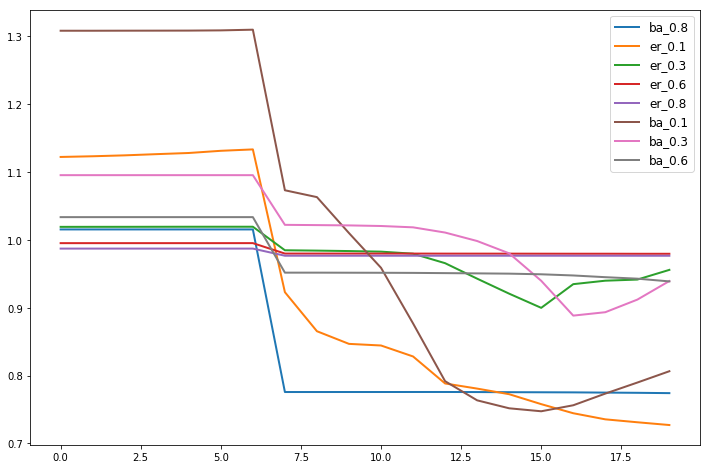

In [194]:
import matplotlib.pyplot as plt

for k , v in performance_dict.items():
    legend_words = []
    plt.figure(figsize=(12,8))
    for kk , vv in v.items():
        legend_words.append(kk)
        plt.plot(vv , linewidth = 2)
    plt.legend(legend_words,fontsize=12)
    
    plt.show()
    
    #break
    

In [ ]:
#torch.save(dqn.state_dict(), 'trained_model/MVC_ER_n{}.pkl'.format(graph_size))
#pickle_save(validation_result , 'validation_result/MVC_ER_n{}_ER.pkl'.format(graph_size))
#pickle_save(ba_result , 'validation_result/MVC_ER_n{}_BA.pkl'.format(graph_size))

In [ ]:
import collections
def degree_hist(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(G)
    plt.axis('off')
    #nx.draw_networkx_nodes(G, pos, node_size=20)
    #nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()


In [ ]:
er_g = nx.erdos_renyi_graph(n = 40, p = 0.1)
nx.draw(er_g)
degree_hist(er_g)

In [ ]:
ba_g = nx.barabasi_albert_graph(n = 40, m = density_to_edge_ba(40,0.1))
nx.draw(ba_g)
degree_hist(ba_g)